## Impact of tides on various things

### Define utils

In [1]:
import numpy as np
import netCDF4 as nc
import glob
import os
from scipy.interpolate import PchipInterpolator

import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
import matplotlib.pyplot as plt

import pandas as pd
from cmcrameri import cm


In [2]:
R_earth = 6.371e6 # m

In [3]:
from proteus.config import read_config
import utils.load_grid as lg

In [4]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

# %matplotlib widget

In [5]:
def readrun(f, stride=1):
    print("Reading files in '%s'..." % f)
    ncdfs = glob.glob(f+"/data/*_atm.nc")
    if len(ncdfs) == 0:
        raise Exception("No files found!")

    years = [float(s.split("/")[-1].split("_")[0]) for s in ncdfs]

    if stride < 0:
        mask = [np.argsort(years)[-1]]
    else:
        mask = np.argsort(years)[::int(stride)]

    ncdfs = np.array([ncdfs[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([lg.readncdf(f) for f in ncdfs])

    print("    Done reading %d files" % len(years))
    print("    Final time = %1.3e years" % years[-1])
    return years, data

def read_helpfile(fpath):
    return pd.read_csv(fpath, sep=r'\s+')



### Do analysis

In [6]:
outname = "output/SIM_b/"
title = "L 98-59 5"

stride = -1

indep_var = "orbit.dummy.H_tide"
indep_lbl = r"Tidal heating [W kg$^{-1}$]"

cmap = cm.batlow

In [7]:
pgrid_dir = "data/" + outname
globber = pgrid_dir + "/case_*/"
print(globber)
cases = glob.glob(globber)

npoints = len(cases)
print("npoints = %d"%npoints)
if npoints < 1:
    raise

data = []
help = []
conf = []
post = []
cnum = []
for folder in cases:
    _,d = readrun(folder, stride=stride)
    data.append( d )
    conf.append( read_config(folder+"init_coupler.toml") )
    help.append( read_helpfile(folder+"runtime_helpfile.csv") )
    cnum.append(int(folder.split("_")[-1].replace("/","")))

statuses = lg.get_statuses(pgrid_dir)

print("Done")

data/output/SIM_b//case_*/


npoints = 600
Reading files in 'data/output/SIM_b/case_00000/'...
    Done reading 1 files
    Final time = 1.255e+06 years
Reading files in 'data/output/SIM_b/case_00001/'...
    Done reading 1 files
    Final time = 2.381e+06 years
Reading files in 'data/output/SIM_b/case_00002/'...
    Done reading 1 files
    Final time = 3.591e+06 years
Reading files in 'data/output/SIM_b/case_00003/'...
    Done reading 1 files
    Final time = 4.649e+06 years
Reading files in 'data/output/SIM_b/case_00004/'...
    Done reading 1 files
    Final time = 5.799e+06 years
Reading files in 'data/output/SIM_b/case_00005/'...
    Done reading 1 files
    Final time = 6.934e+06 years
Reading files in 'data/output/SIM_b/case_00006/'...
    Done reading 1 files
    Final time = 8.089e+06 years
Reading files in 'data/output/SIM_b/case_00007/'...
    Done reading 1 files
    Final time = 9.400e+06 years
Reading files in 'data/output/SIM_b/case_00008/'...
    Done reading 1 files
    Final time = 1.037e+07 ye

In [8]:
indep_vals = []
for i in range(npoints):
    indep_vals.append(lg.descend_get(conf[i],indep_var))
indep_vals = np.array(indep_vals)
indep_max = np.amax(np.abs(indep_vals))
indep_min = np.amin(np.abs(indep_vals))

isorted = np.argsort(indep_vals)

linthresh = np.amin(indep_vals[indep_vals>0])

In [9]:
norm = mpl.colors.SymLogNorm(vmin=indep_min, vmax=indep_max, linthresh=linthresh)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

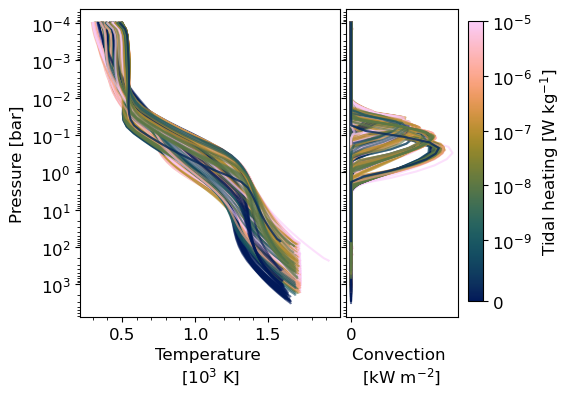

In [10]:
plt.close("all")
fig,axs = plt.subplots(1,2, sharey=True, width_ratios=(0.7, 0.3), figsize=(5,4))
(ax0,ax1) = axs

al = 0.6

for i in range(npoints):
    ds = data[i][-1]
    st = statuses[cnum[i]]

    x = ds["tmpl"] / 1e3
    y = ds["pl"] * 1e-5

    if not (10 <= st <= 19 ):
        print("Skip case %d"%cnum[i])
        continue

    indep_val = lg.descend_get(conf[i],indep_var)
    col = sm.to_rgba(indep_val)
    zorder=isorted[::-1][i]

    ax0.plot(x,y, color=col, zorder=2*zorder, alpha=al)

    # m = np.argwhere(ds["fl_cnvct"] > 0)
    # x_mask = x[m]
    # y_mask = y[m]
    # ax0.scatter(x_mask,y_mask, color=col, s=20, edgecolors='w', marker='o', zorder=2*zorder+1)

    x = ds["fl_cnvct"]/1e3
    ax1.plot(x,y, color=col, zorder=2*zorder, alpha=al)

ax0.set_yscale("log")
ax0.invert_yaxis()
ax0.set_ylabel("Pressure [bar]")
ax0.set_xlabel("Temperature \n" + r"[$10^3$ K]")
ax0.xaxis.set_major_locator(MultipleLocator(0.5))
ax0.xaxis.set_minor_locator(MultipleLocator(0.1))

ax1.set_xlabel("Convection \n" + r"[kW m$^{-2}$]")
ax1.xaxis.set_major_locator(MultipleLocator(1.0))
ax1.xaxis.set_minor_locator(MultipleLocator(0.5))

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label(indep_lbl)

fig.subplots_adjust(wspace=0.03)
plt.show()

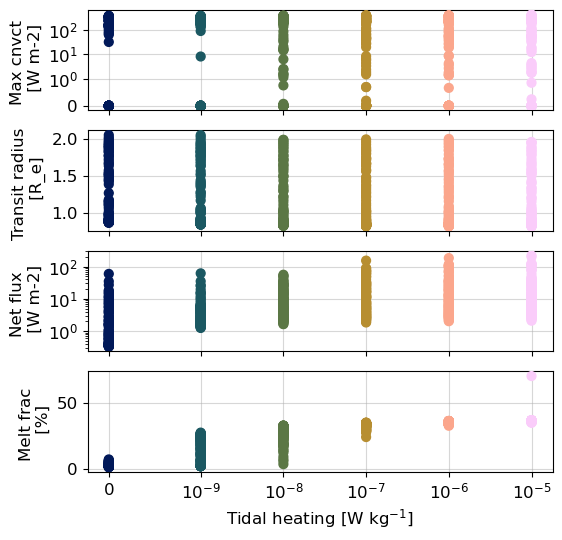

In [11]:
fig,axs = plt.subplots(4,1, sharex=True, figsize=(6,6))

ms=40
lvl = 0

pltdat = [{"x":[], "y":[], "c":[], "ylbl":"", "yscl":"linear", "ysl":1} for _ in range(len(axs))]

for i in range(npoints):
    ds = data[i][-1]
    hf = help[i].iloc[-1]
    indep_val = lg.descend_get(conf[i],indep_var)
    col = sm.to_rgba(indep_val)

    pltdat[0]["ylbl"] = "Max cnvct \n [W m-2]"
    pltdat[0]["yscl"] = "symlog"
    pltdat[0]["ythr"]  = 1
    pltdat[0]["x"].append(indep_val)
    pltdat[0]["y"].append(np.amax(ds["fl_cnvct"]))
    pltdat[0]["c"].append(col)

    axs[1].yaxis.set_major_locator(MultipleLocator(1))
    axs[1].yaxis.set_minor_locator(MultipleLocator(0.25))
    pltdat[1]["ylbl"] = "Transit radius \n [R_e]"
    pltdat[1]["x"].append(indep_val)
    pltdat[1]["y"].append((hf["R_int"] + hf["z_obs"]) / R_earth)
    pltdat[1]["c"].append(col)

    pltdat[2]["ylbl"] = "Net flux \n [W m-2]"
    pltdat[2]["yscl"] = "log"
    pltdat[2]["x"].append(indep_val)
    pltdat[2]["y"].append(ds["fl_tot"][lvl])
    pltdat[2]["c"].append(col)

    axs[3].yaxis.set_major_locator(MultipleLocator(20))
    axs[3].yaxis.set_minor_locator(MultipleLocator(10))
    pltdat[3]["ylbl"] = "Melt frac \n [%]"
    pltdat[3]["x"].append(indep_val)
    pltdat[3]["y"].append(hf["Phi_global"] * 100)
    pltdat[3]["c"].append(col)

for i,q in enumerate(pltdat):
    axs[i].grid(zorder=-1, alpha=0.5)
    axs[i].scatter(q["x"], q["y"], color=q["c"], s=ms, zorder=i+3)
    axs[i].set_ylabel(pltdat[i]["ylbl"])
    if pltdat[i]["yscl"] == "symlog":
        axs[i].set_yscale("symlog", linthresh=pltdat[i]["ythr"])
    else:
        axs[i].set_yscale(pltdat[i]["yscl"])

axs[-1].set_xlabel(indep_lbl)
axs[-1].set_xscale("symlog", linthresh=linthresh)

plt.show()

In [12]:
def plot_sensitivity(var='T_surf', box_plot=False):

    fig, ax = plt.subplots(1,1, figsize=(4,3))

    x = {}
    for k in indep_vals:
        x[k] = []

    for i in range(npoints):
        ds = data[i][-1]
        hf = help[i].iloc[-1]
        k = lg.descend_get(conf[i],indep_var)
        st = statuses[cnum[i]]

        if not (10 <= st <= 19 ):
            print("Skip case %d"%cnum[i])
            continue

        if var == 'fl_cnvct':
            y = np.amax(ds["fl_cnvct"])
        elif var == 'T_surf':
            y = hf["T_surf"]
        elif var == "Phi_global":
            y = hf["Phi_global"] * 100.0
        elif var == "rho_obs":
            y = hf["rho_obs"] * 0.001
        elif var == "contrast_ratio":
            y = hf["contrast_ratio"] * 1e9
        else:
            raise Exception(f"Invalid variable name {var}")
        x[k].append(y)

    for k in set(indep_vals):
        if k > 0.0:
            x_pos = k
            x_wid = x_pos/2
        else:
            x_pos = 0.0
            x_wid = linthresh/2

        if box_plot:
            bplot = ax.boxplot(x[k], positions=[x_pos], widths=[x_wid], zorder=10,
                            patch_artist=True, showfliers=True) #, showmeans=True, meanline=True)
            bplot['boxes'][0].set_facecolor('lightgrey') # make opaque

        else:
            ys = x[k]
            xs = [x_pos for _ in ys]
            ax.scatter(xs, ys, zorder=10, color='k', alpha=0.8, s=12 )

    ax.set_xlabel(r"Tidal heating [W kg$^{-1}$]")

    if var == 'fl_cnvct':
        ax.set_ylabel(r"Convection [W m$^{-2}$]")
        ax.yaxis.set_major_locator(MultipleLocator(500))
        ax.yaxis.set_minor_locator(MultipleLocator(100))
        ax.set_ylim(bottom=0, top=3000)

    elif var == 'T_surf':
        ax.set_ylabel(r"Surface temperature [K]")
        ax.yaxis.set_major_locator(MultipleLocator(250))
        ax.yaxis.set_minor_locator(MultipleLocator(50))
        ax.set_ylim(bottom=1500, top=3000)

    elif var == 'Phi_global':
        ax.set_ylabel(r"Mantle melt fraction [%]")
        ax.yaxis.set_major_locator(MultipleLocator(20))
        ax.yaxis.set_minor_locator(MultipleLocator(10))
        ax.set_ylim(bottom=0, top=100)

    elif var == 'rho_obs':
        ax.set_ylabel(r"Bulk density [g cm$^{-3}$]")
        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.2))

    elif var == 'contrast_ratio':
        ax.set_ylabel(r"Contrast ratio [ppb]")
        # ax.yaxis.set_major_locator(MultipleLocator(1))
        # ax.yaxis.set_minor_locator(MultipleLocator(0.2))

    xticks = np.unique(sorted(indep_vals))
    ax.set_xlim(left=-linthresh/2, right=np.amax(indep_vals)*2)
    ax.set_xscale("symlog", linthresh=linthresh)
    ax.set_xticks(xticks)
    ax.grid(axis='y', zorder=0)

    plt.show()


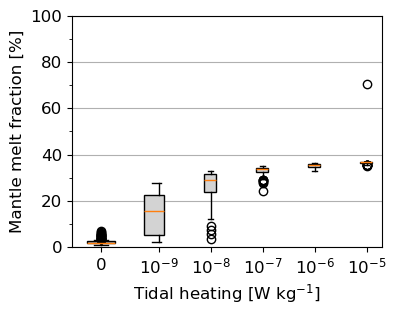

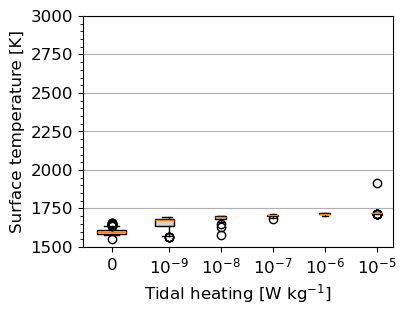

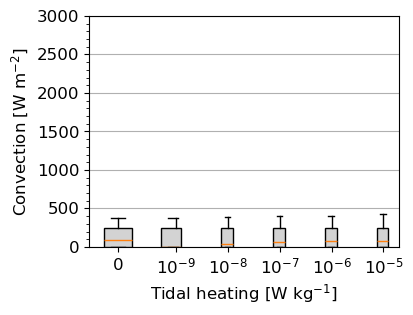

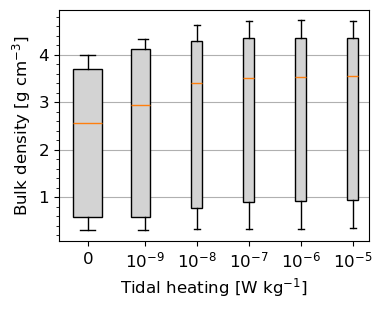

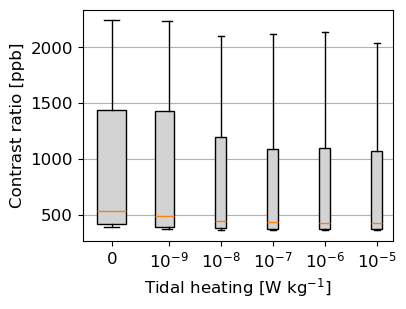

In [13]:
for var in ("Phi_global", "T_surf", "fl_cnvct", "rho_obs", "contrast_ratio"):
    plot_sensitivity(var=var, box_plot=True)
